# Analyze CSV data files with Vanna

world top companies
- https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide

## Setup

In [1]:
from glob import glob
import os
import re
from time import time
from datetime import datetime 

import pandas as pd
import sqlite3

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

In [2]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

### load SQLite db with CSV data

In [3]:
file_db_path = "../data/company_rank.sqlite"
file_db = os.path.abspath(os.path.expanduser(file_db_path))
print(file_db)

/home/papagame/projects/wgong/py4kids/lesson-18-ai/vanna/note_book/data/company_rank.sqlite


In [4]:
LOAD_CSV = True # False
if LOAD_CSV:
    csv_files = glob("../data/company_rank/*.csv")
    print(csv_files)
    
    conn = sqlite3.connect(file_db)
    df_dict = {}
    col_map = {}
    for i in csv_files:
        t = i.split("/")[-1].lower().replace("companies_ranked_by_","").replace(".csv","")
        df = pd.read_csv(i)
        c_map = {c:c.lower() for c in df.columns}
        c_map['price (GBP)'] = 'price_gbp'
        # print(f"col_map: {c_map}")
        table_name = f"t_{t}"
        print(f"\n Loading data from file: '{i}' \n into table_name: '{table_name}'")
        col_map[table_name] = c_map
        df.rename(columns=c_map, inplace=True)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        df_dict[table_name] = df
    conn.close()

['../data/company_rank/Companies_ranked_by_Market_Cap.csv', '../data/company_rank/Companies_ranked_by_P_E_ratio.csv', '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv', '../data/company_rank/Companies_ranked_by_Earnings.csv', '../data/company_rank/country_region.csv', '../data/company_rank/Companies_ranked_by_Revenue.csv']
Loading data from file: '../data/company_rank/Companies_ranked_by_Market_Cap.csv' 
 into table_name: 't_market_cap'
Loading data from file: '../data/company_rank/Companies_ranked_by_P_E_ratio.csv' 
 into table_name: 't_p_e_ratio'
Loading data from file: '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv' 
 into table_name: 't_dividend_yield'
Loading data from file: '../data/company_rank/Companies_ranked_by_Earnings.csv' 
 into table_name: 't_earnings'
Loading data from file: '../data/company_rank/country_region.csv' 
 into table_name: 't_country_region'
Loading data from file: '../data/company_rank/Companies_ranked_by_Revenue.csv' 
 into table_n

In [5]:
# verify
VERIFY_DB = True # False # 
if VERIFY_DB:
    conn = sqlite3.connect(file_db)
    sql_stmt = f"select name from {table_name} limit 10"
    sql_stmt = """ 
    select country from t_revenue
     UNION 
    select country from t_earnings
     UNION 
    select country from t_market_cap
     UNION 
    select country from t_p_e_ratio
     UNION 
    select country from t_dividend_yield
    """
    df_2 = pd.read_sql_query(sql_stmt, conn).fillna("")
    country_list = df_2["country"].to_list()
    # print(df_2)
    conn.close()

In [6]:
country_list

['',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'British Virgin Islands',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Malaysia',
 'Malta',
 'Mexico',
 'Monaco',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay'

### Fix country

### Setup LLM

In [7]:
model_name = 'deepseek-coder-v2'
config = {
    'model': model_name,   # 'mistral' # "starcoder2"
}

clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [8]:
vn = MyVanna(config=config)

In [9]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [10]:
# file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [11]:
vn.run_sql_is_set

True

In [12]:
if clean_and_train:
    vn.remove_collections()

## Prepare Training Data

### Add DDL SQL statements

You only need to train once. Do not train again unless you want to add more training data.

In [13]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [14]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,..."
1,table,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\..."
2,table,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE..."
3,table,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n..."
4,table,"CREATE TABLE ""t_country_region"" (\n""country"" T..."
5,table,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ..."


### Add business terms

In [15]:
business_docs = [
"""
Introduction:
This dataset ranks top companies in the world.
Its analysis delves into the financial performance of top companies by examining key metrics such as 
- revenue, 
- earnings, 
- market capitalisation, 
- P/E ratio, 
- dividend yield. 

By comparing these metrics, we gain a comprehensive understanding of a company's scale, 
profitability, market value, and growth potential. 
Through visualisations, the analysis also explores correlations between these metrics and offers 
insights into country-level performance, highlighting economic dominance across various sectors. 
This holistic approach provides a multi-dimensional view of global financial powerhouses, investor confidence, 
and regional economic trends.
""",

"""
Terminologies:
TTM : Trailing Twelve Months
PE : Price over Earning Raio
LOV : List-of-Values
""",

"""
Key Metrics 1. Revenue (TTM):
Table Name: t_revenue ;
Definition: This is the total income generated by a company from its operations in the last twelve months ;
Potential Insights: High revenue often indicates market dominance or high sales volume. Comparing revenues can reveal which companies are the largest in terms of business volume.
""",

"""
Key Metrics 2. Earnings (TTM):
Table Name: t_earnings
Definition: This refers to the company's profit after taxes and expenses over the trailing twelve months.
Potential Insights: Companies with high earnings are more efficient at converting revenue into profit, suggesting better profitability or cost management. A comparison of earnings provides insight into profitability rather than just scale.
""",

"""
Key Metrics 3. Market Capitalisation (Market Cap):
Table Name: t_market_cap
Definition: Market cap is the total value of a company's outstanding shares of stock, calculated as stock price multiplied by the number of shares. It indicates the company’s size in the stock market.
Potential Insights: High market cap usually indicates investor confidence in the company. Comparing market cap among the top 15 companies reveals their relative size in financial markets.
""",

"""
Key Metrics 4. P/E Ratio (TTM):
Table Name: t_p_e_ratio
Definition: Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings.
Potential Insights: A high P/E ratio may indicate that investors expect high growth in the future, while a low P/E ratio could imply undervaluation or scepticism about growth. Companies are compared by their growth prospects or current valuation.
""",

"""
Key Metrics 5. Dividend Yield (TTM):
Table Name: t_dividend_yield
Definition: Dividend yield is a financial ratio that shows how much a company pays out in dividends each year relative to its share price.
Potential Insights: High dividend yield may indicate that a company returns more income to shareholders. It’s particularly useful for income-focused investors.
""",

"""
List-of-Value (LOV) mapping: Country to Region
Table Name: t_country_region
Definition: This table translate country to region, can be used to join on country column with other tables to rollup metrics at region-level
""",
]

In [16]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    # vn.train(documentation="In the chinook database invoice means order")
    for bus_doc in business_docs:
        vn.train(documentation=bus_doc)

Adding ddl: CREATE TABLE "t_market_cap" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "marketcap" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_p_e_ratio" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "pe_ratio_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_dividend_yield" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "dividend_yield_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_earnings" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "earnings_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_country_region" (
"country" TEXT,
  "region" TEXT,
  "sub_region" TEXT,
  "country_code_2" TEXT,
  "country_code_3" TEXT,
  "note" TEXT
)
Adding ddl: CREATE TABLE "t_revenue" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "revenue_ttm" INTEGER,
  "price_gbp" REAL,
  "country" TEXT
)
Adding documentation....
Adding documentation....
Adding documentation.

In [17]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,051f4399-1594-56de-b0bd-9f74053fd5ff-ddl,None,"CREATE TABLE ""t_country_region"" (\n""country"" T...",ddl
1,75de6b21-b3df-53ea-a36f-9af69e40913b-ddl,None,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ...",ddl
2,87669f00-5543-579a-a95c-fec096be48ed-ddl,None,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE...",ddl
3,b94bb579-73d6-521b-86de-5d5e599bbde5-ddl,None,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,...",ddl
4,e0a92066-0804-52fd-be4e-437ac10622de-ddl,None,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n...",ddl
5,f68c7d4a-806f-55f0-962d-74de7018e372-ddl,None,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\...",ddl
0,160dc6f8-f66d-56f9-bf0d-f924c831f5fd-doc,None,\nTerminologies:\nTTM : Trailing Twelve Months...,documentation
1,29b133c0-6d77-5089-b7f4-d74f133c70d3-doc,None,\nKey Metrics 4. P/E Ratio (TTM):\nTable Name:...,documentation
2,5d1a1060-01ff-5a14-8fb8-6a79f1cbff38-doc,None,\nKey Metrics 2. Earnings (TTM):\nTable Name: ...,documentation
3,5ec048b8-d9ec-56c9-8ea3-bc955617643e-doc,None,\nKey Metrics 3. Market Capitalisation (Market...,documentation


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

In [18]:
ts_start = time()

```sql
SELECT name FROM sqlite_master WHERE type = 'table';
```


In [19]:
questions = [
"Can you list all tables in the SQLite database catalog?",

"which table stores Company P/E Ratio, Hint: No need to generate SQL",

"which table stores Company Dividend Yield, Hint: No need to generate SQL",

"which table stores Company Market Cap, Hint: No need to generate SQL",

"which table stores Company Revenue, Hint: No need to generate SQL",

"which table stores Company Earnings",

"Find 10 companyies with the lowest PE Ratio around 10 in Germany",   

"Find top 10 companyies in the United States with the heighest market cap",

"Find the customer with the most invoices ",

"""
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: "Asia" is a region name, you need to join "t_p_e_ratio" table with "t_country_region" table 
on "country" columns to answer this question .
""",

"""
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,
""",
]

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 2:  Can you list all tables in the SQLite database catalog?


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "region" TEX

SELECT name FROM sqlite_master WHERE type='table'


[( <DataFrame> )]
queried dataframe


,name
0,t_market_cap
1,t_p_e_ratio
2,t_dividend_yield
3,t_earnings
4,t_country_region
5,t_revenue



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame and it has been created using the query provided
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=1,
        title={"text": "Number of Tables"}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)),
                                  cells=dict(values=[df['name']]))])

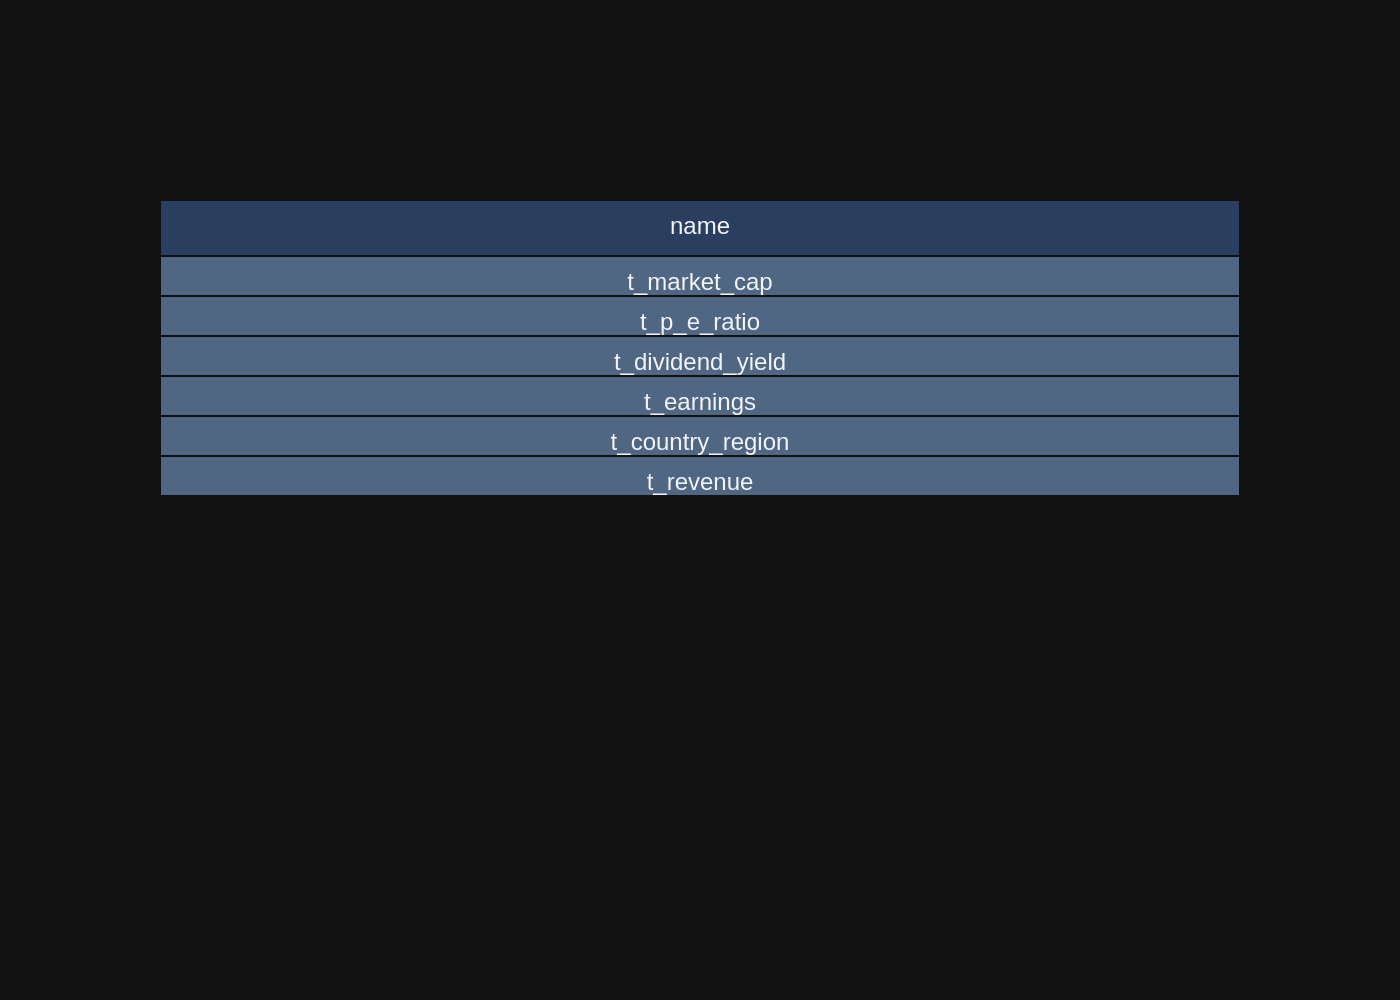

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 3:  which table stores Company P/E Ratio, Hint: No need to generate SQL


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( LLM RESPONSE )]
 t_p_e_ratio

[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "sy

SELECT * FROM t_p_e_ratio


[( <DataFrame> )]
queried dataframe


,rank,name,symbol,pe_ratio_ttm,price_gbp,country
0,1,Imperial Petroleum,IMPP,0.109943,3.108797,Greece
1,2,Vertex Energy,VTNR,0.188889,0.092197,United States
2,3,Spin Master,TOY.TO,0.224758,17.414443,Canada
3,4,Performance Shipping,PSHG,0.225293,1.467916,Greece
4,5,TherapeuticsMD,TXMD,0.340956,1.280093,United States
...,...,...,...,...,...,...
9907,9908,MBX Biosciences,MBX,0.000000,18.500389,United States
9908,9909,Bicara Therapeutics,BCAX,-70.666700,18.896608,United States
9909,9910,Zensho Holdings,7550.T,275.203000,42.447877,Japan
9910,9911,BKV Corporation,BKV,-12.410500,13.867596,United States



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        title={"text": "Company P/E Ratio"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Scatter(x=df['rank'], y=df['pe_ratio_ttm'], mode='markers', text=df['name'] + '<br>Symbol: ' + df['symbol'] + '<br>Country: ' + df['country'])])
    fig.update_layout(title="Company P/E Ratios", xaxis_title="Rank", yaxis_title="P/E Ratio TTM")

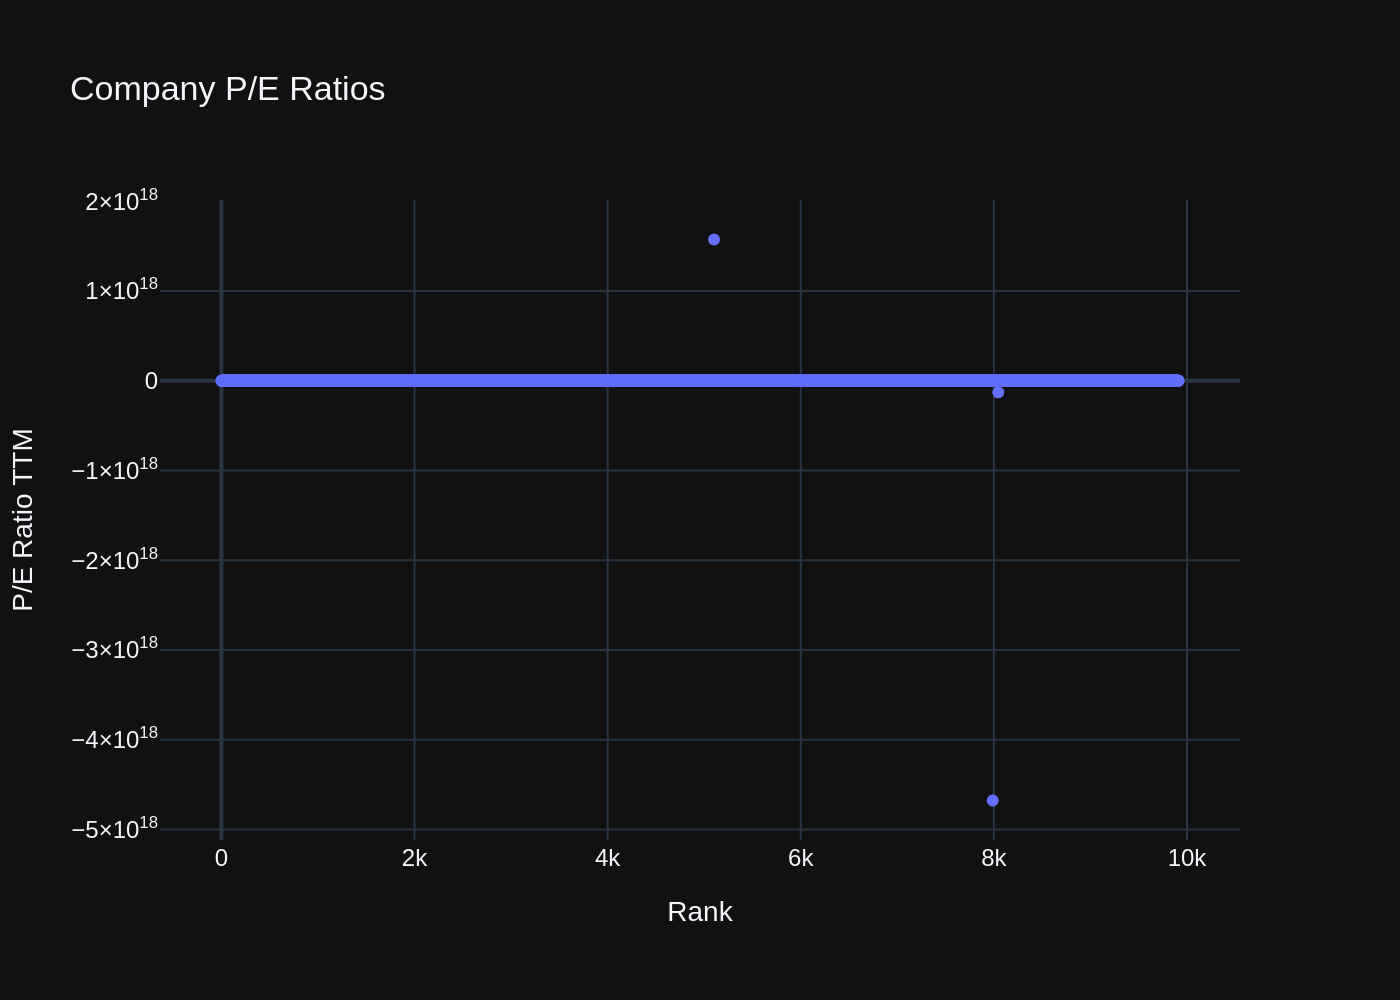

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 4:  which table stores Company Dividend Yield, Hint: No need to generate SQL


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( LLM RESPONSE )]
 The table that stores information about a company's dividend yield is `t_dividend_yield`.

[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TE

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 2 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 5:  which table stores Company Market Cap, Hint: No need to generate SQL


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n 

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( LLM RESPONSE )]
 The table that stores company market cap is `t_market_cap`.

[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\

SELECT 't_market_cap' AS table_name


[( <DataFrame> )]
queried dataframe


,table_name
0,t_market_cap



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

fig = go.Figure(data=[go.Indicator(mode="number", value=df['table_name'].iloc[0])])
fig.update_layout(title={'text': "Company Market Cap Table"})

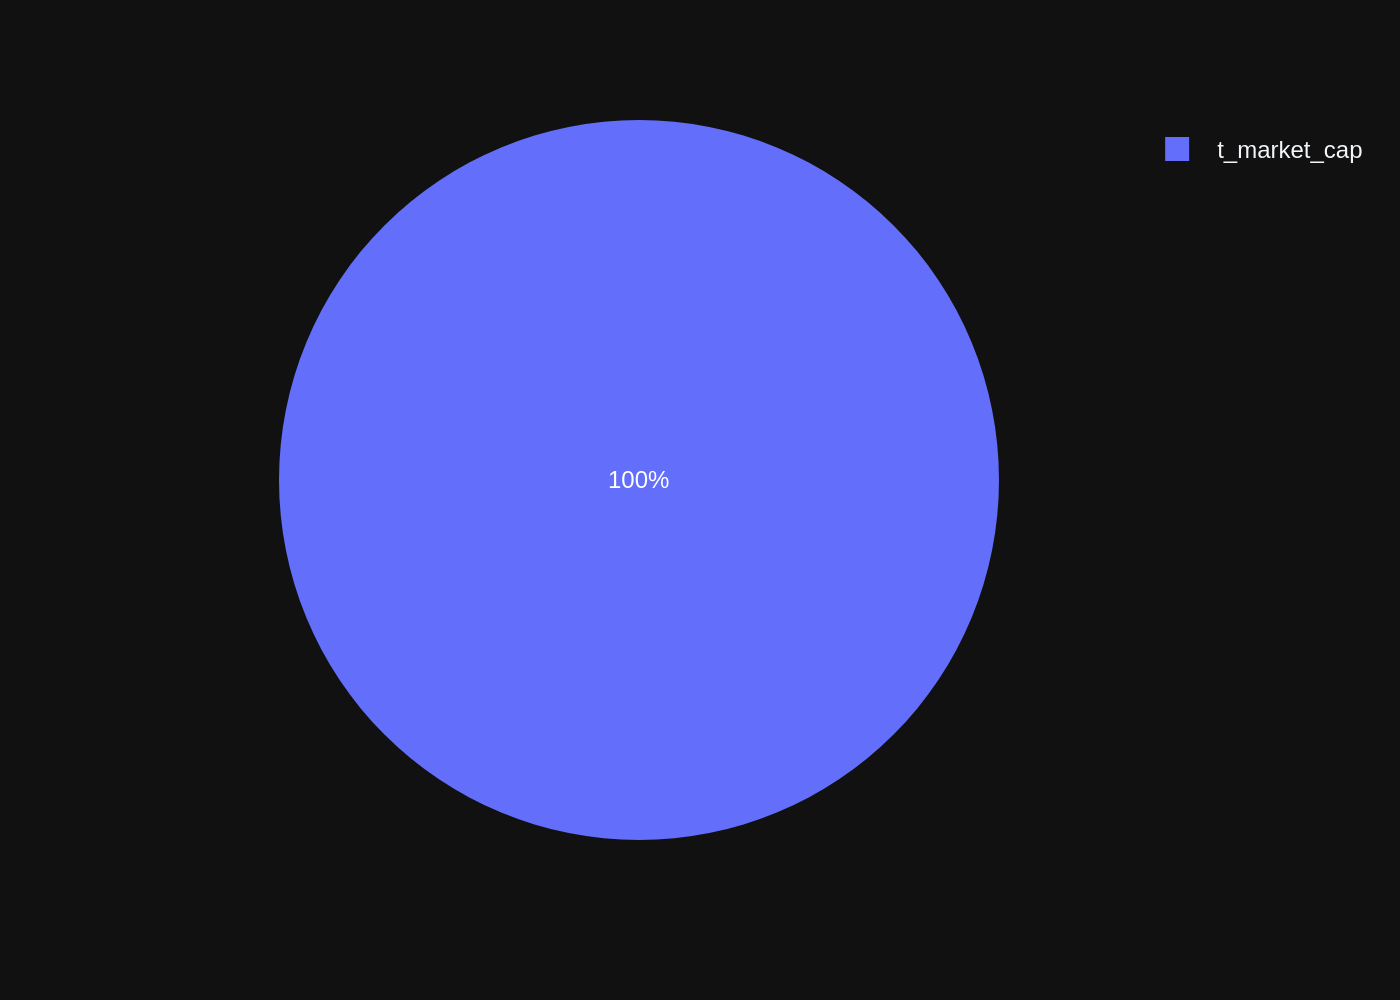

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 6:  which table stores Company Revenue, Hint: No need to generate SQL


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "n

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( LLM RESPONSE )]
 t_revenue

[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 2 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\

SELECT * FROM t_revenue


[( <DataFrame> )]
queried dataframe


,rank,name,symbol,revenue_ttm,price_gbp,country
0,1,Walmart,WMT,665035000000,61.029186,United States
1,2,Amazon,AMZN,604334000000,143.454209,United States
2,3,Saudi Aramco,2222.SR,495354806850,5.505405,Saudi Arabia
3,4,Sinopec,600028.SS,435696880608,0.748295,China
4,5,PetroChina,601857.SS,429671599508,0.969769,China
...,...,...,...,...,...,...
9907,9908,Kinnevik,KINV-A.ST,-755524598,6.067929,Sweden
9908,9909,Sofina,SOF.VI,-1960650040,212.106043,Belgium
9909,9910,Quilter,QLT.L,-4921465842,1.331998,United Kingdom
9910,9911,M&G plc,MNG.L,-10545825404,2.073004,United Kingdom



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['revenue_ttm'].iloc[0],
        title={"text": "Company Revenue (TTM)"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['revenue_ttm'])])

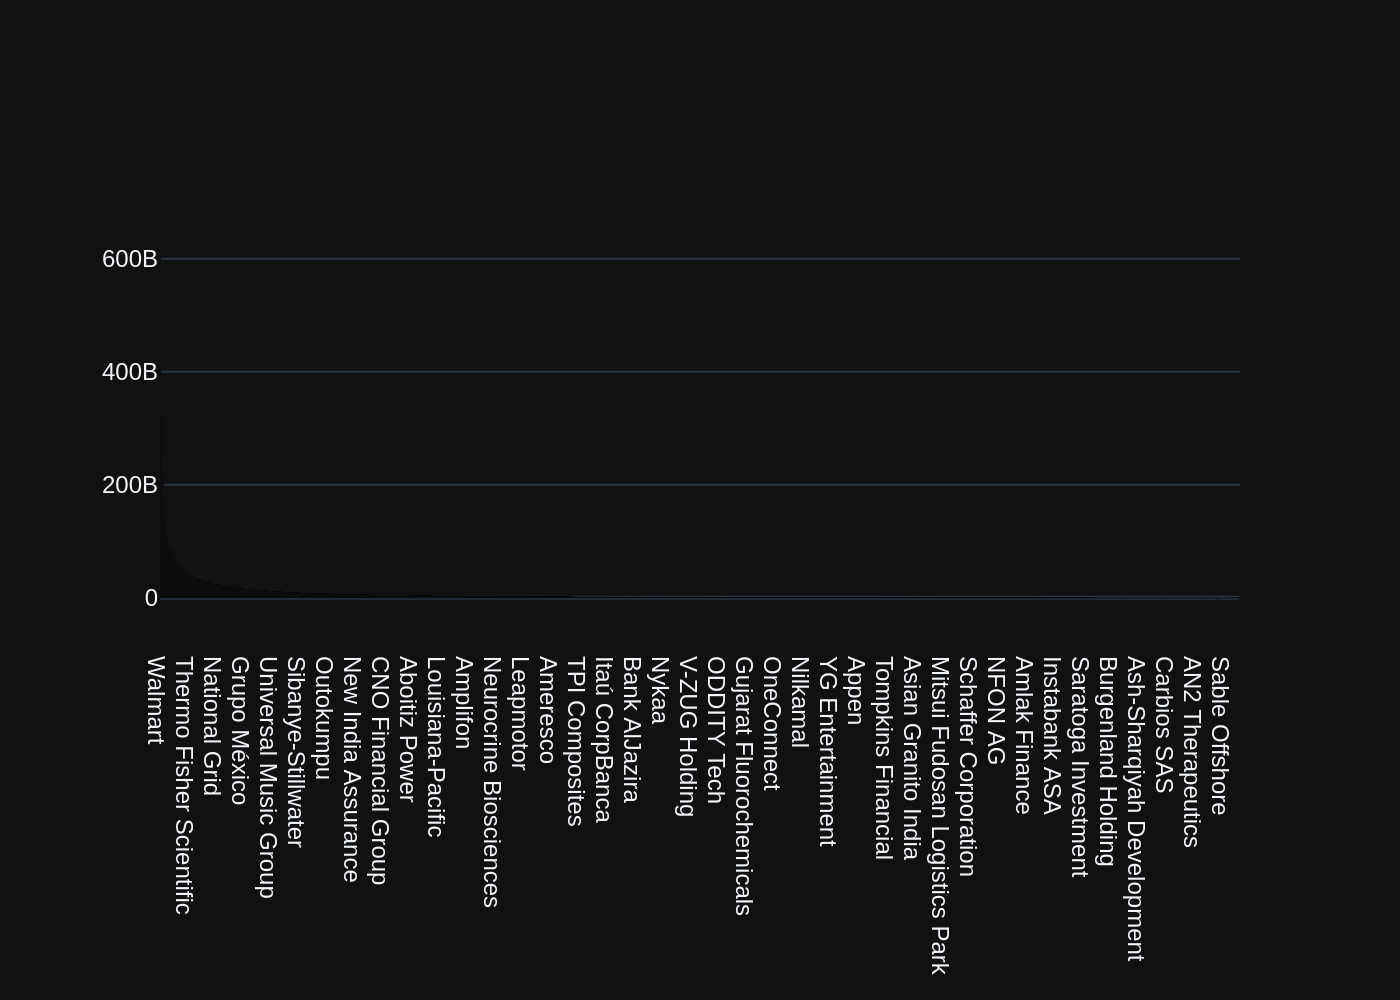

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 7:  which table stores Company Earnings


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol

SELECT name FROM sqlite_master WHERE type='table' AND tbl_name='t_earnings'


[( <DataFrame> )]
queried dataframe


,name
0,t_earnings



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame and it contains a single column 'name' with the table name
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=len(df),
        number={'suffix': " Company Earnings"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure()

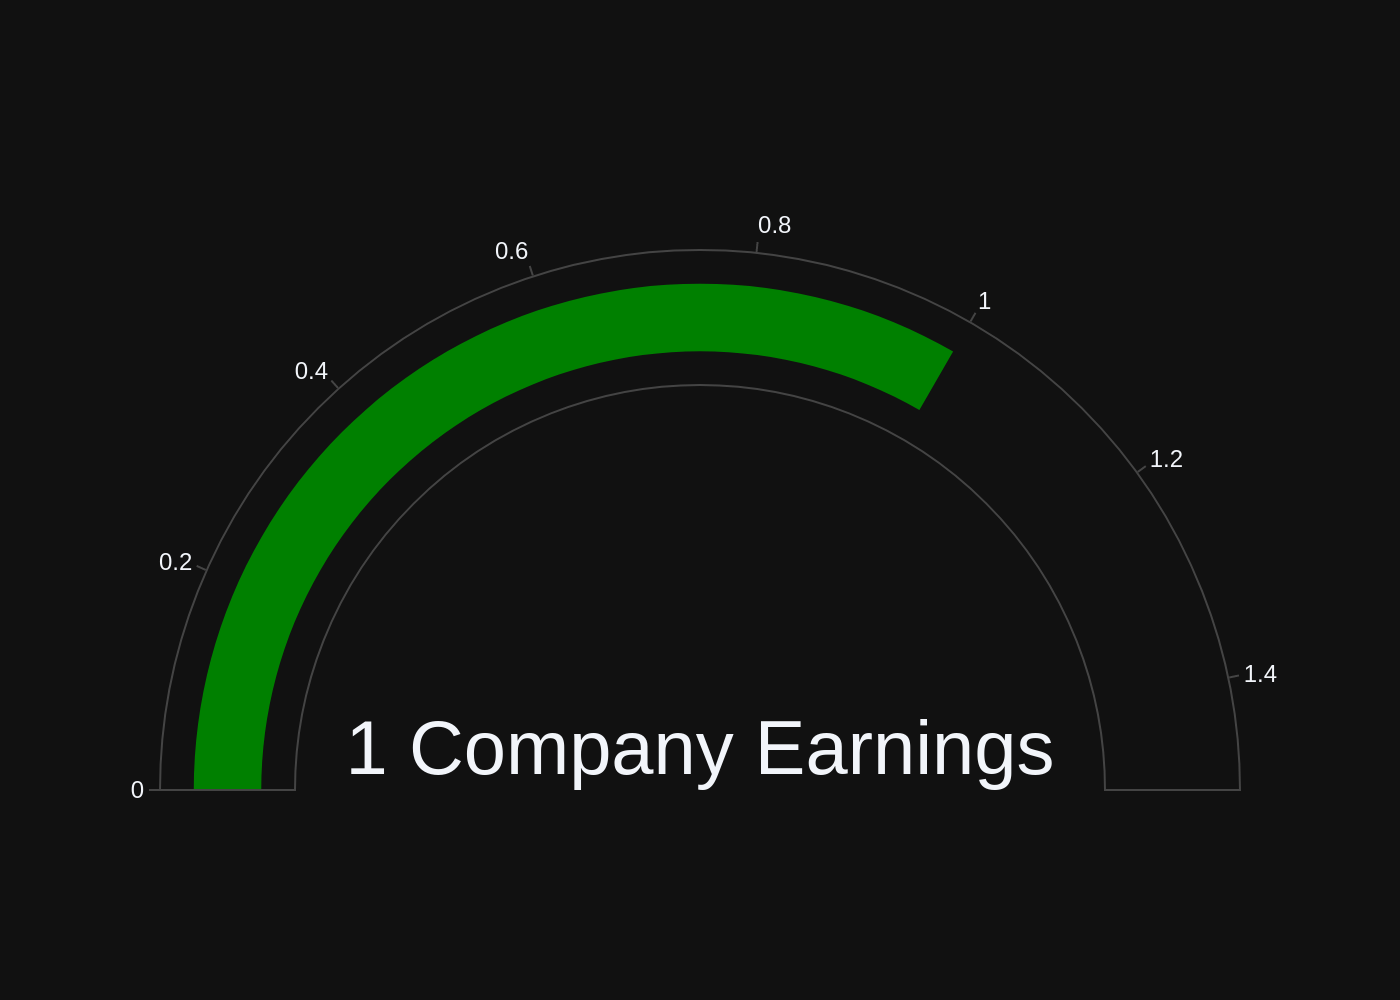



# QUESTION - 8:  Find 10 companyies with the lowest PE Ratio around 10 in Germany



Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "co

SELECT name
FROM t_p_e_ratio
WHERE country = 'Germany' AND pe_ratio_ttm BETWEEN 8 AND 12
ORDER BY pe_ratio_ttm ASC
LIMIT 10


[( <DataFrame> )]
queried dataframe


,name
0,Hornbach Baumarkt
1,Delignit AG
2,Elbstein AG
3,CompuGroup Medical
4,EnBW Energie
5,Nürnberger Versicherung
6,UmweltBank
7,Traton
8,LEWAG Holding
9,Sto SE &amp; Co. KGaA



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

if df['name'].nunique() == 1:
    fig = go.Figure(data=[go.Indicator(
        mode="number", value=df['name'].iloc[0], title={"text": "Company"}
    )])
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=range(len(df)), orientation='h')])

fig.update_layout(title='Top 10 Companies with Lowest PE Ratio in Germany (8-12)', xaxis_title='Company Name', yaxis_title='Rank')

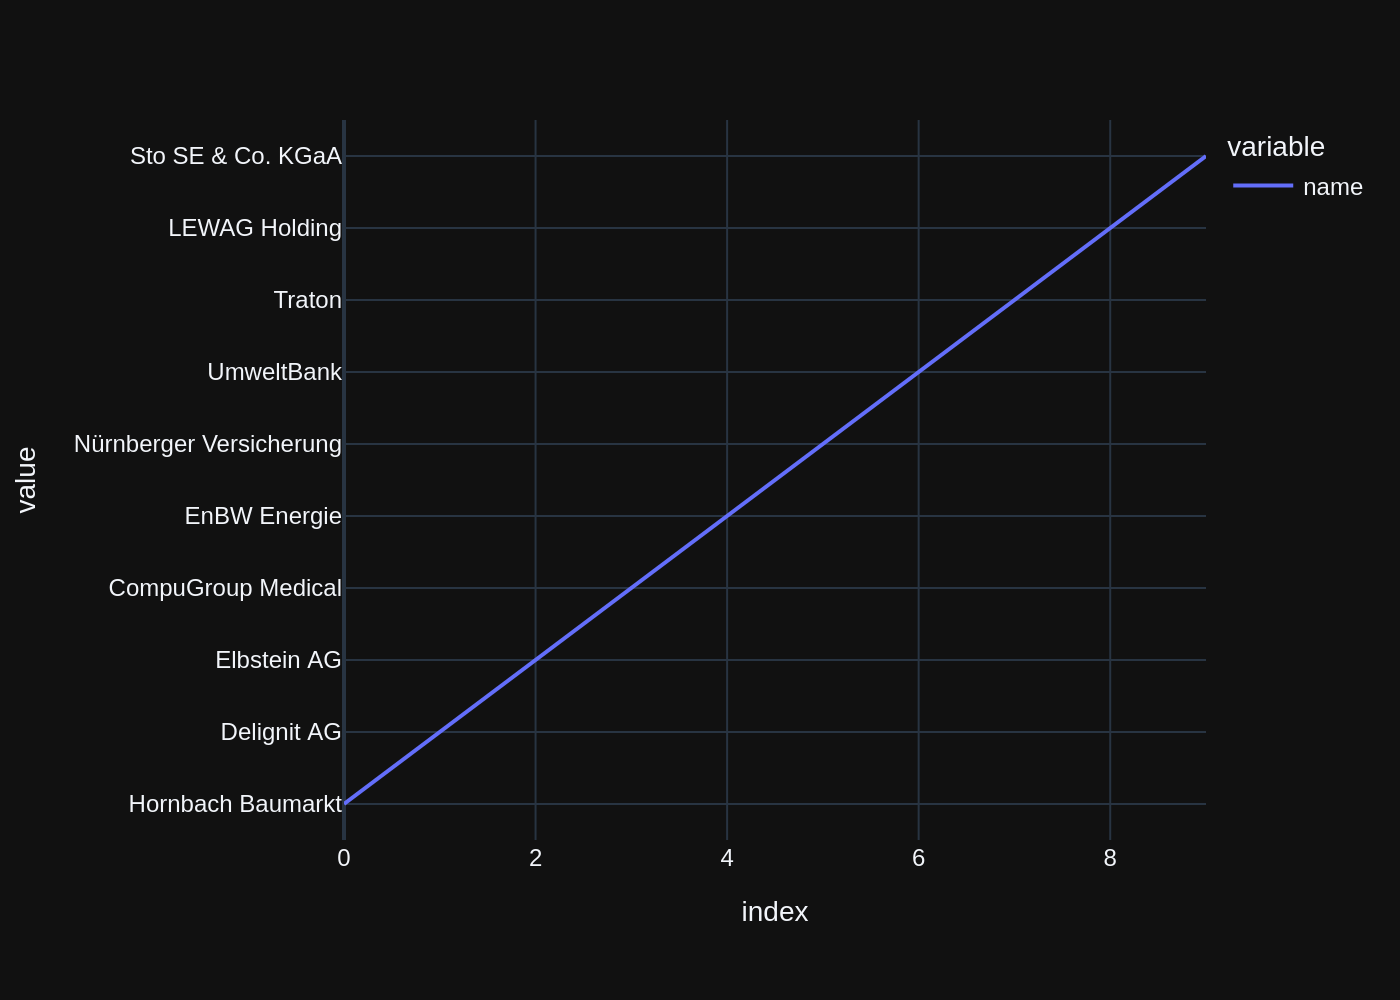

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6




# QUESTION - 9:  Find top 10 companyies in the United States with the heighest market cap



Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "co

SELECT name FROM t_market_cap WHERE country = 'United States' ORDER BY marketcap DESC LIMIT 10


[( <DataFrame> )]
queried dataframe


,name
0,Apple
1,Microsoft
2,NVIDIA
3,Alphabet (Google)
4,Amazon
5,Meta Platforms (Facebook)
6,Berkshire Hathaway
7,Tesla
8,Broadcom
9,Eli Lilly



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

if len(df) == 1:
    fig = go.Figure(go.Indicator(mode="number", value=df['marketcap'].iloc[0], number={'prefix': "USD"}))
else:
    fig = px.bar(df, x='name', y='marketcap', labels={'marketcap': 'Market Cap'}, text_auto='.2s')
fig.update_layout(title='Top 10 Companies in the United States by Market Cap', xaxis_title='Company Name', yaxis_title='Market Cap (USD)')

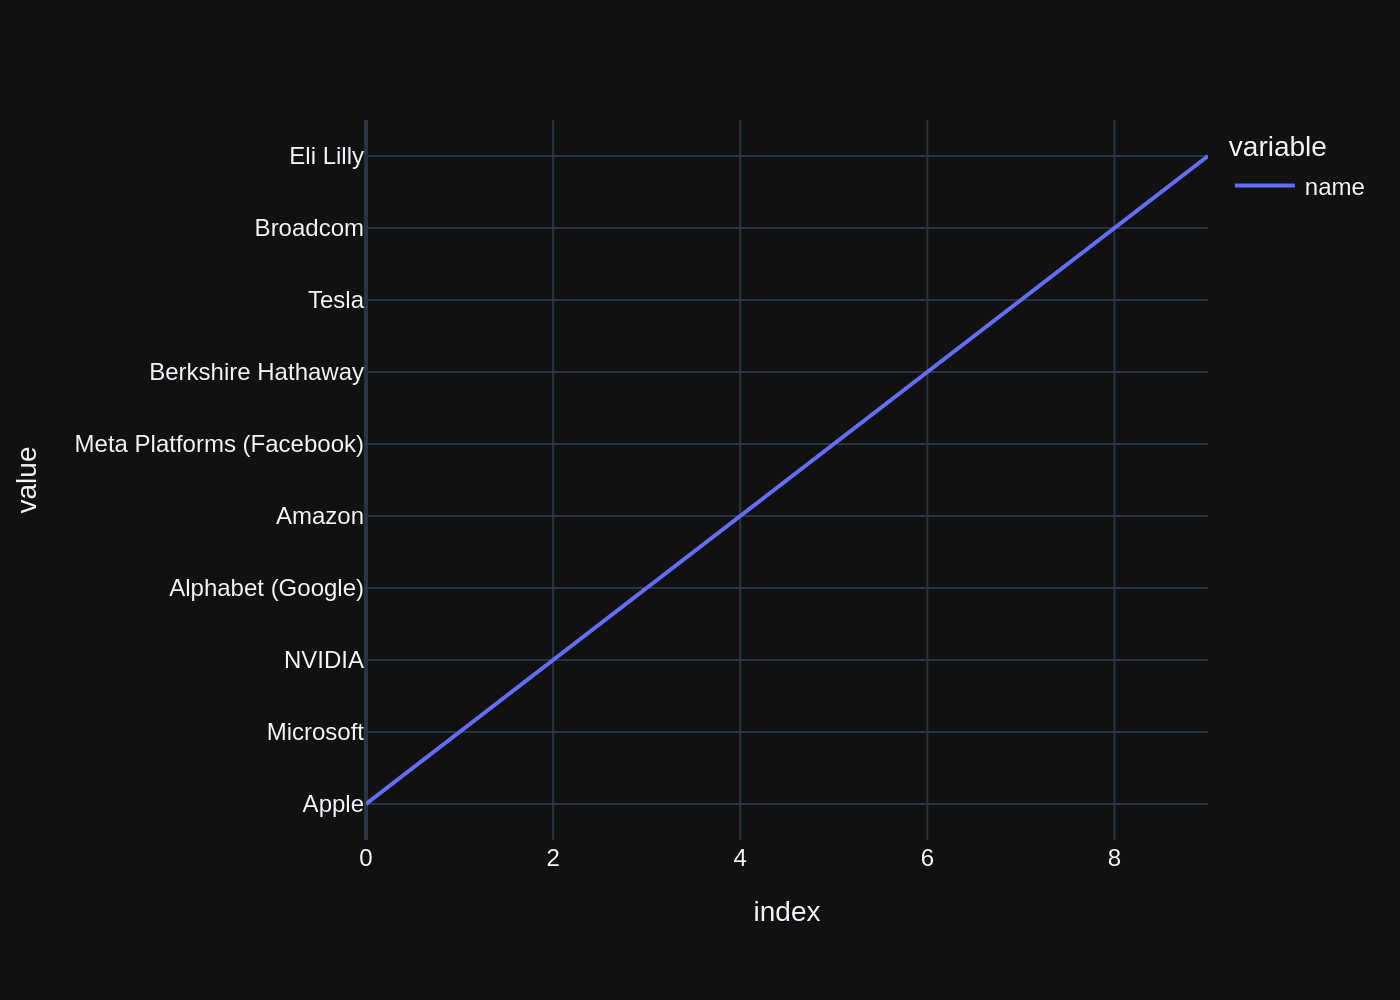

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 10:  Find the customer with the most invoices 


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" 

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, COUNT(i.InvoiceId) AS NumberOfInvoices
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY NumberOfInvoices DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "region" TEXT,\n  "sub_region" TEXT,\n  "country_code_2" TEXT,\n  "country_code_3" TEXT,\n  "note" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" RE

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, COUNT(i.InvoiceId) AS NumberOfInvoices
FROM customer c -- Notice the lowercase "c" for the table name
JOIN invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY NumberOfInvoices DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 2 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "region" TEXT,\n  "sub_region" TEXT,\n  "country_code_2" TEXT,\n  "country_code_3" TEXT,\n  "note" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" RE

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 11:  
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: "Asia" is a region name, you need to join "t_p_e_ratio" table with "t_country_region" table 
on "country" columns to answer this question .



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue"

SELECT t_p_e_ratio.name, t_p_e_ratio.pe_ratio_ttm
FROM t_p_e_ratio
JOIN t_country_region ON t_p_e_ratio.country = t_country_region.country
WHERE t_country_region.region = 'Asia' AND t_p_e_ratio.pe_ratio_ttm > 40
ORDER BY t_p_e_ratio.pe_ratio_ttm DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm
0,Ceragon Networks,1.573740e+18
1,National Industries Group Holding,3.459630e+05
2,Gulf Investment House Company,2.369150e+05
3,Kuwait Cement Company,1.047660e+05
4,Kuwait Investment Company,6.837150e+04



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        title={"text": "PE Ratio"},
        number={'prefix': ""}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['name'], y=df['pe_ratio_ttm'], name='PE Ratio'))
    fig.update_layout(title='Top 5 Companies in Asia with Highest PE Ratio above 40', barmode='group')

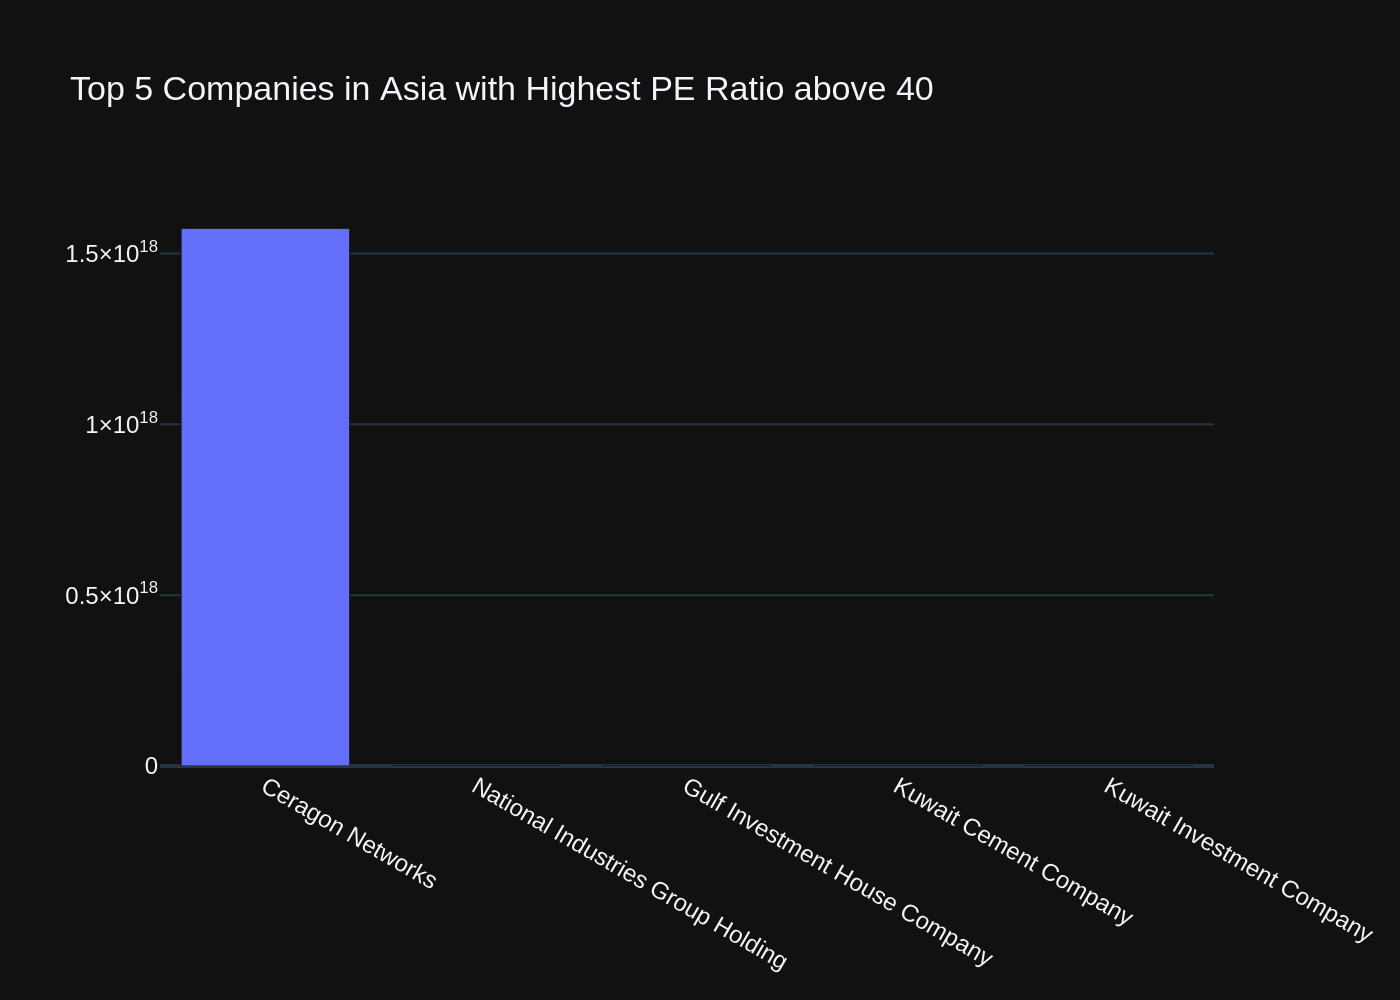

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 12:  
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,




Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "co

SELECT name, pe_ratio_ttm FROM t_p_e_ratio WHERE pe_ratio_ttm BETWEEN 20 AND 30 ORDER BY pe_ratio_ttm LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm
0,Fresenius,20.0133
1,Equatorial Energia,20.0178
2,Viper Energy Partners,20.0268
3,Avanza Bank,20.0304
4,Select Energy Services,20.0370



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        title={"text": f"PE Ratio for {df['name'].values[0]}"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['pe_ratio_ttm'])])

fig.update_layout(title='Top 5 Companies with Lowest PE Ratio in Range 20-30',
                  xaxis_title='Company Name',
                  yaxis_title='PE Ratio')

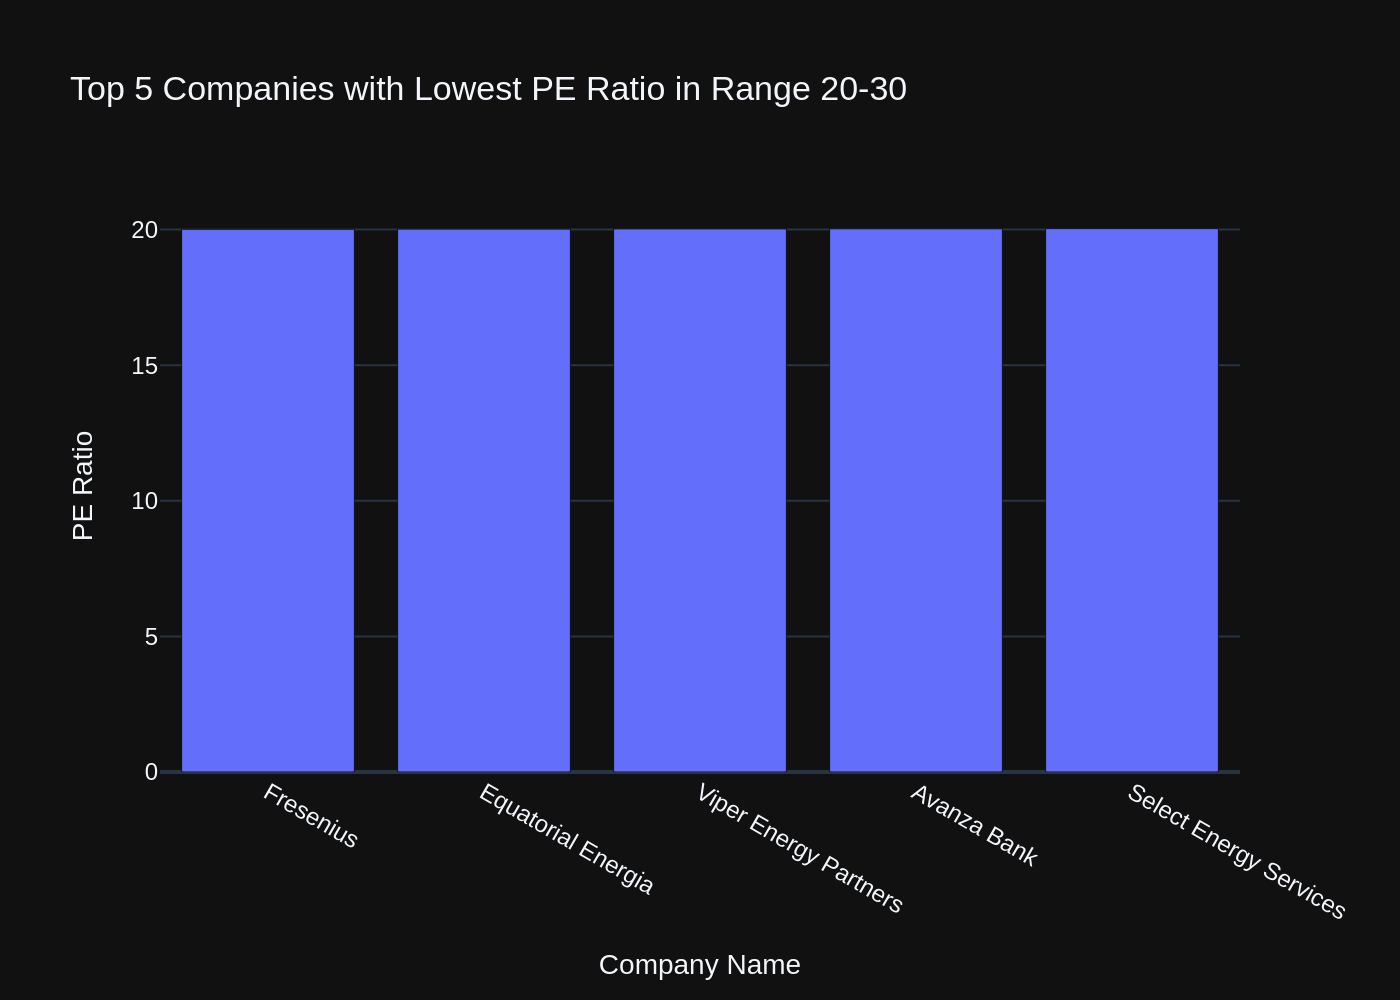

In [20]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)

### Check completion time

In [21]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"Completed tests:\n================\n run on host '{hostname}' \n with LLM model '{model_name}' \n took {elapsed_time:.2f} sec")

Completed tests:
 run on host 'papa-game' 
 with LLM model 'deepseek-coder-v2' 
 took 1789.61 sec
